# EDA

In [24]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_selection import f_classif

def load_ecoli():
    ecoli = fetch_ucirepo(id=39)
    X = ecoli.data.features
    y = ecoli.data.targets.iloc[:, 0]  # get the first column as a series
    print("E. coli dataset loaded.")
    print(f"Metadata: {ecoli.metadata}")
    print(f"Variables: {ecoli.variables}")

    return X, y


X, y = load_ecoli()


E. coli dataset loaded.
Metadata: {'uci_id': 39, 'name': 'Ecoli', 'repository_url': 'https://archive.ics.uci.edu/dataset/39/ecoli', 'data_url': 'https://archive.ics.uci.edu/static/public/39/data.csv', 'abstract': 'This data contains protein localization sites', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 336, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': ['Sequence'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1996, 'last_updated': 'Thu Feb 15 2024', 'dataset_doi': '10.24432/C5388M', 'creators': ['Kenta Nakai'], 'intro_paper': {'ID': 391, 'type': 'NATIVE', 'title': 'A Probabilistic Classification System for Predicting the Cellular Localization Sites of Proteins', 'authors': 'P. Horton, K. Nakai', 'venue': 'Intelligent Systems in Molecular Biology', 'year': 1996, 'journal': None, 'DOI': None, 'URL': 'https://www.semanticscholar.o

In [9]:
print("\n--- Basic dataset overview ---")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nTarget distribution:")
print(y.value_counts())

print("\n--- Summary statistics ---")
print(X.describe())

print("\n--- Missing values ---")
print(X.isnull().sum())


--- Basic dataset overview ---
Shape of X: (336, 7)
Shape of y: (336,)

First few rows of features:
    mcg   gvh   lip  chg   aac  alm1  alm2
0  0.49  0.29  0.48  0.5  0.56  0.24  0.35
1  0.07  0.40  0.48  0.5  0.54  0.35  0.44
2  0.56  0.40  0.48  0.5  0.49  0.37  0.46
3  0.59  0.49  0.48  0.5  0.52  0.45  0.36
4  0.23  0.32  0.48  0.5  0.55  0.25  0.35

Target distribution:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64

--- Summary statistics ---
              mcg         gvh         lip         chg         aac        alm1  \
count  336.000000  336.000000  336.000000  336.000000  336.000000  336.000000   
mean     0.500060    0.500000    0.495476    0.501488    0.500030    0.500179   
std      0.194634    0.148157    0.088495    0.027277    0.122376    0.215751   
min      0.000000    0.160000    0.480000    0.500000    0.000000    0.030000   
25%      0.340000    0.400000    0.480000    0.500000    0.420000 

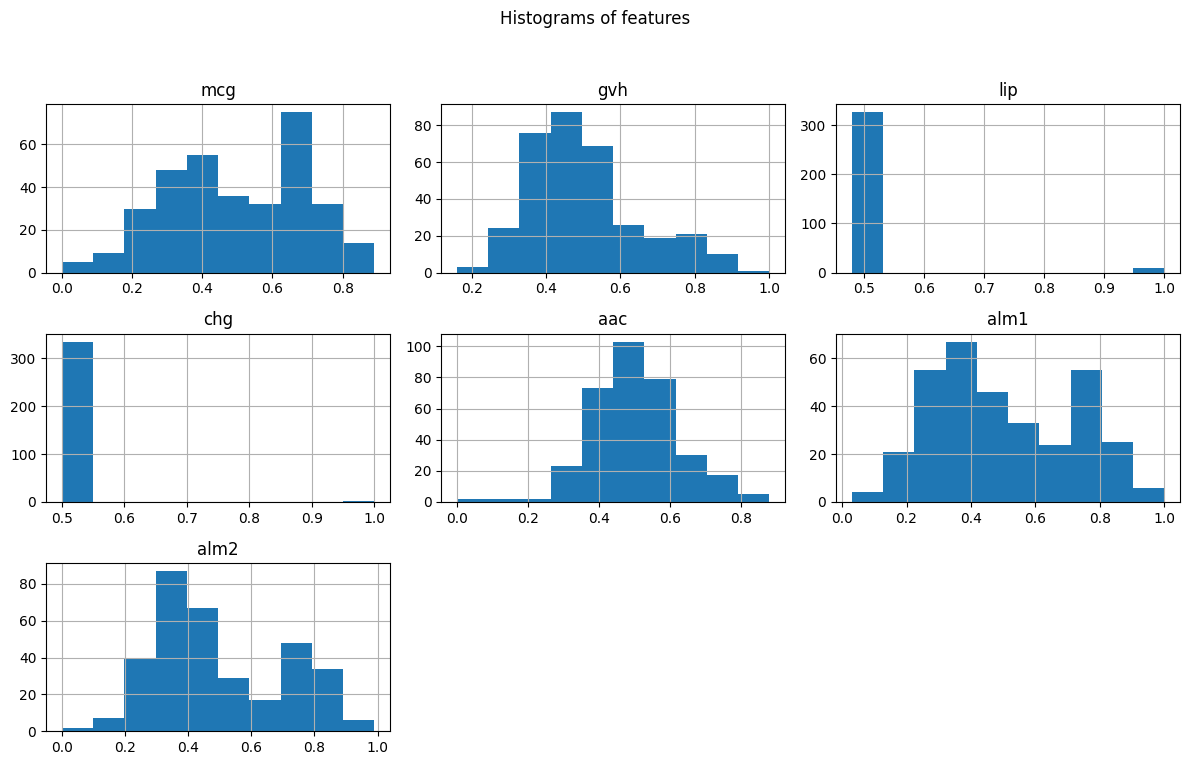

In [10]:
X.hist(figsize=(12, 8))
plt.suptitle("Histograms of features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


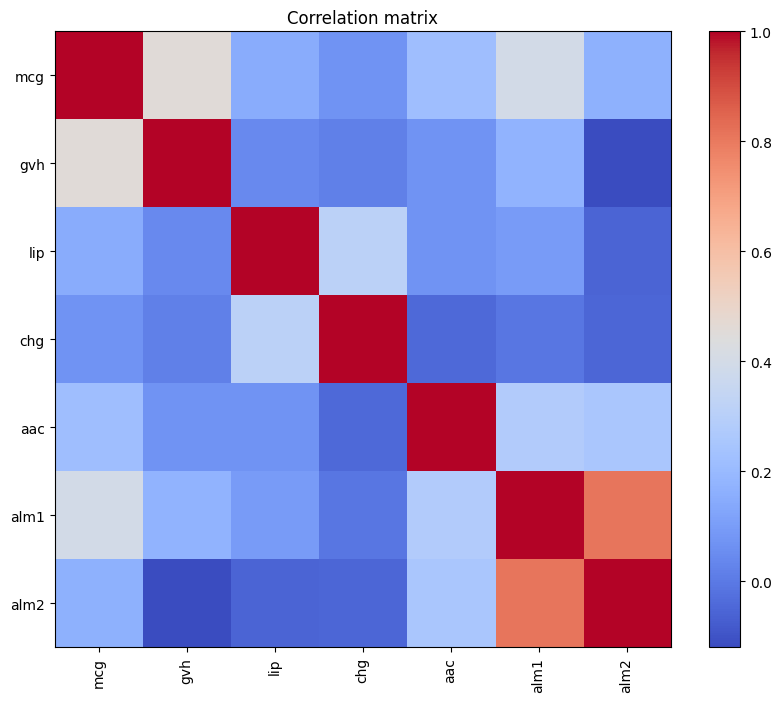

In [11]:
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation matrix")
plt.show()

In [19]:
# preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

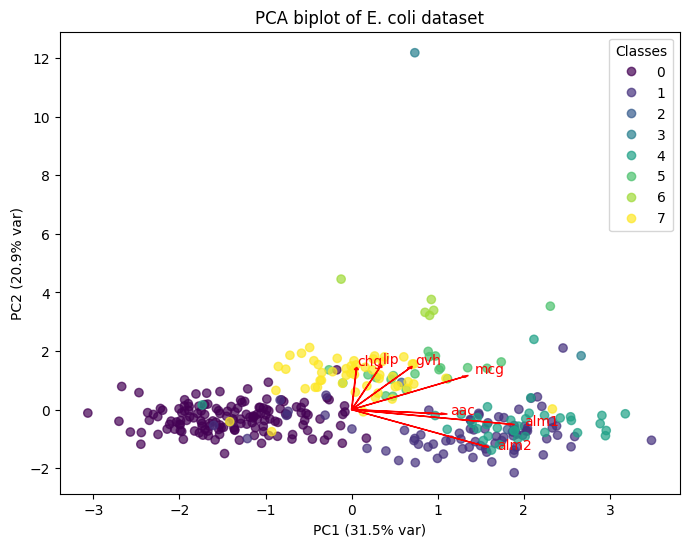


--- PCA Loadings ---
           PC1       PC2
mcg   0.433018  0.372656
gvh   0.223986  0.470296
lip   0.109517  0.481777
chg   0.018169  0.455609
aac   0.345907 -0.047453
alm1  0.607070 -0.164281
alm2  0.511679 -0.413546

Top features on PC1:
alm1    0.607070
alm2    0.511679
mcg     0.433018
aac     0.345907
gvh     0.223986
Name: PC1, dtype: float64


In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

def biplot(scores, loadings, feature_names, pc1=0, pc2=1, scale=3):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(scores[:, pc1], scores[:, pc2], c=pd.factorize(y)[0], cmap='viridis', alpha=0.7)
    plt.xlabel(f"PC{pc1+1} ({pca.explained_variance_ratio_[pc1]*100:.1f}% var)")
    plt.ylabel(f"PC{pc2+1} ({pca.explained_variance_ratio_[pc2]*100:.1f}% var)")
    plt.title("PCA biplot of E. coli dataset")
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[pc1, i]*scale, loadings[pc2, i]*scale, 
                  color='r', width=0.005, head_width=0.05)
        plt.text(loadings[pc1, i]*scale*1.1, loadings[pc2, i]*scale*1.1, feature, color='r')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

loadings = pca.components_
biplot(X_pca, loadings, X.columns)

print("\n--- PCA Loadings ---")
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=["PC1", "PC2"])
print(pca_loadings)
print("\nTop features on PC1:")
print(pca_loadings["PC1"].abs().sort_values(ascending=False).head(5))


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


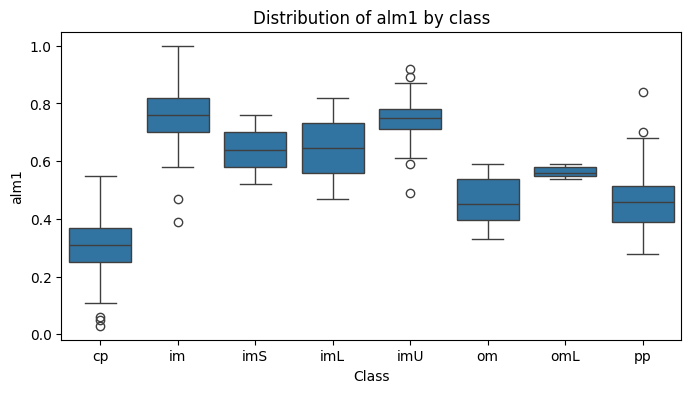

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


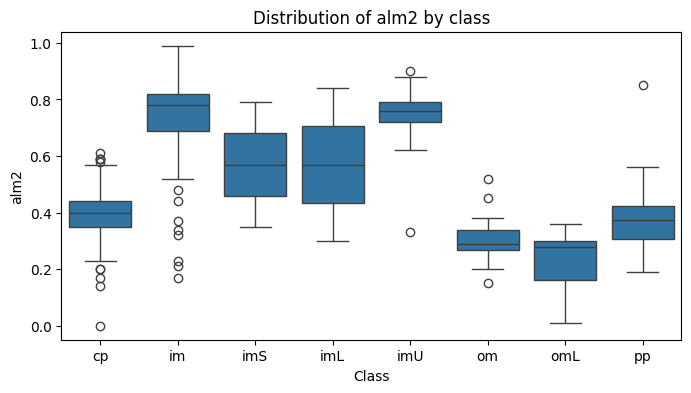

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


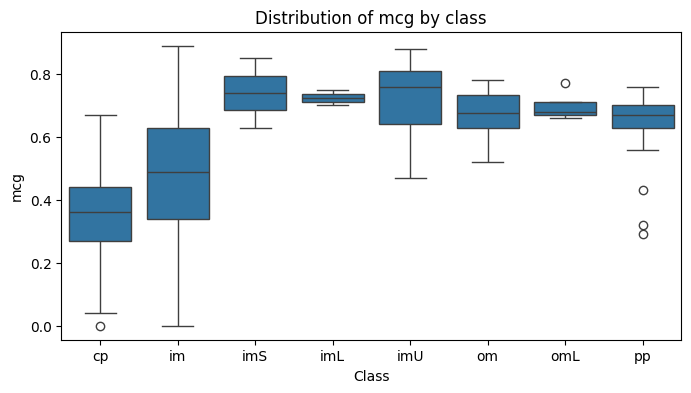

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


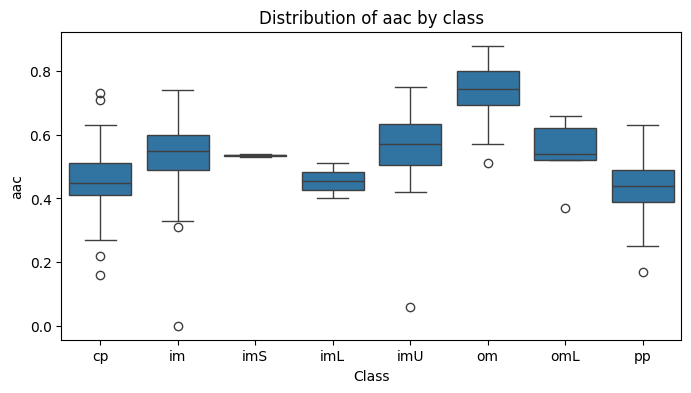

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


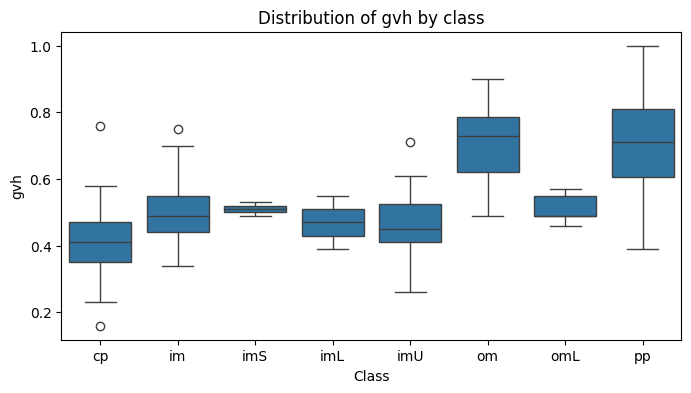

In [28]:

top_features = ['alm1', 'alm2', 'mcg', 'aac', 'gvh']
for feature in top_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=y, y=X[feature])
    plt.title(f"Distribution of {feature} by class")
    plt.xlabel("Class")
    plt.ylabel(feature)
    plt.show()

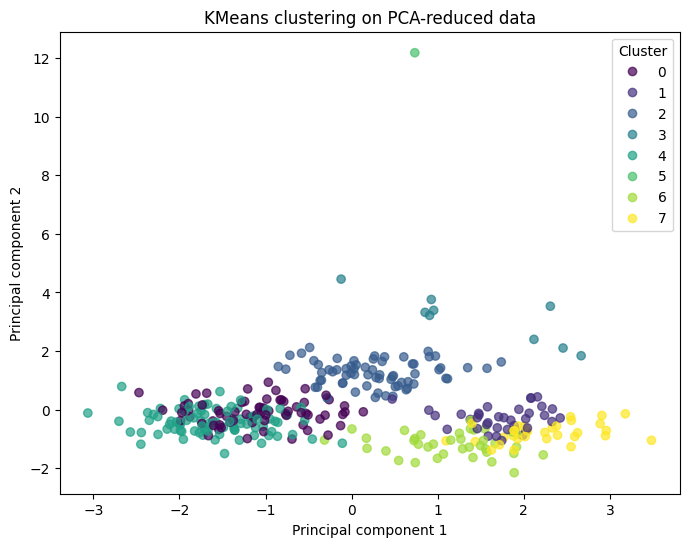

In [ ]:
# 4. KMeans clustering on PCA-reduced data
n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(y, kmeans_labels)
print(f"\nK-Means clustering ARI: {ari:.3f}")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("KMeans clustering on PCA-reduced data")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

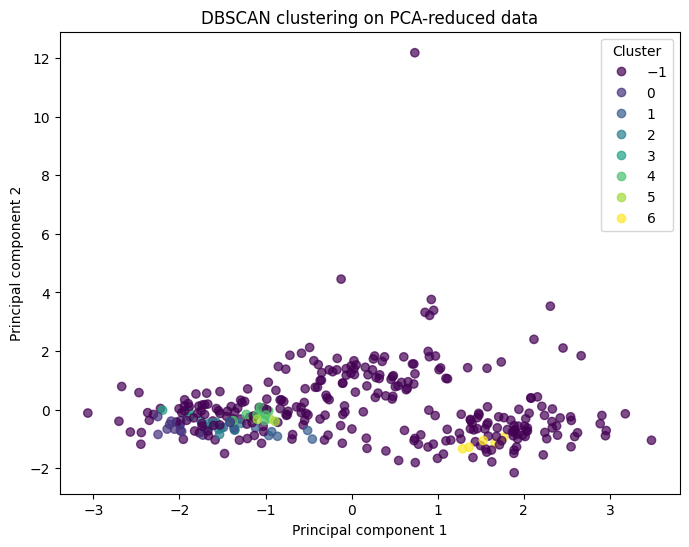

In [15]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap='viridis', alpha=0.7)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("DBSCAN clustering on PCA-reduced data")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()



--- Classification report (Random Forest) ---
              precision    recall  f1-score   support

          cp       0.94      1.00      0.97        46
          im       0.77      0.85      0.81        20
         imL       0.00      0.00      0.00         0
         imS       0.00      0.00      0.00         1
         imU       1.00      0.64      0.78        11
          om       1.00      0.86      0.92         7
         omL       1.00      1.00      1.00         1
          pp       0.87      0.87      0.87        15

    accuracy                           0.89       101
   macro avg       0.70      0.65      0.67       101
weighted avg       0.90      0.89      0.89       101



/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

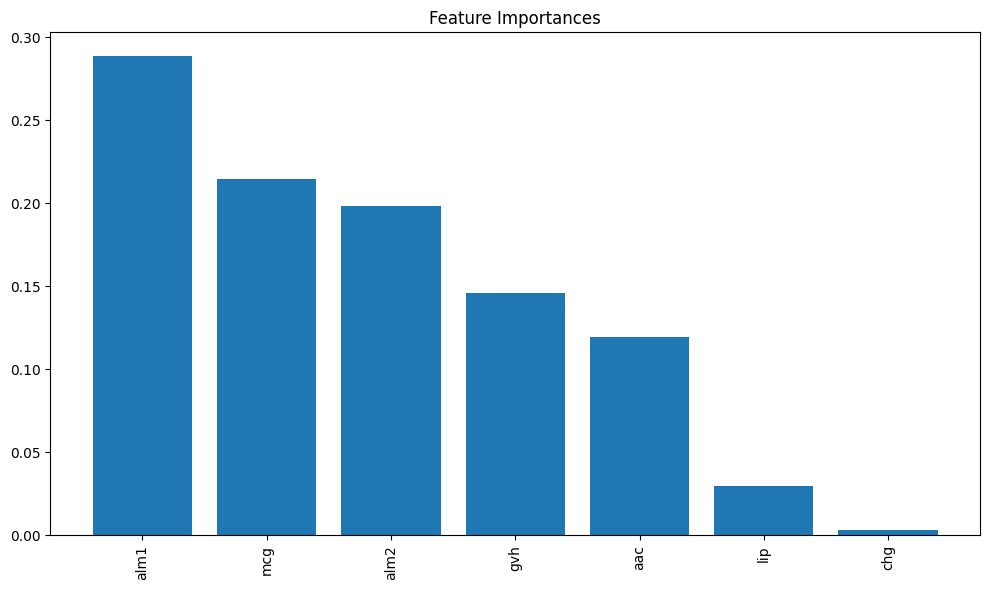

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\n--- Classification report (Random Forest) ---")
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
F, p = f_classif(X_scaled, y)
print("\nANOVA F-test results:")
for name, f_val, p_val in zip(X.columns, F, p):
    print(f"  {name}: F={f_val:.2f}, p={p_val:.3e}")


ANOVA F-test results:
  mcg: F=52.34, p=8.304e-50
  gvh: F=61.94, p=2.652e-56
  lip: F=109.46, p=6.843e-82
  chg: F=46.58, p=1.322e-45
  aac: F=28.17, p=2.762e-30
  alm1: F=181.38, p=1.026e-108
  alm2: F=93.65, p=2.364e-74
